I0000 00:00:1715856928.855356 2908488 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1715856928.875456 2909063 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA RTX A6000/PCIe/SSE2


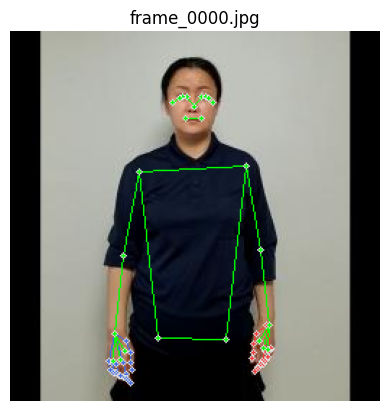

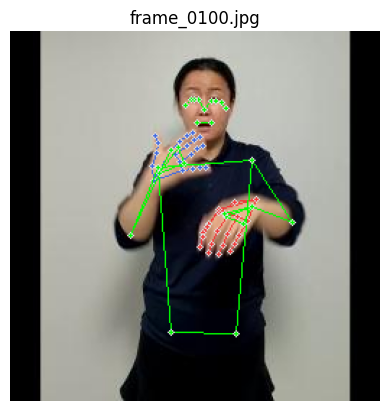

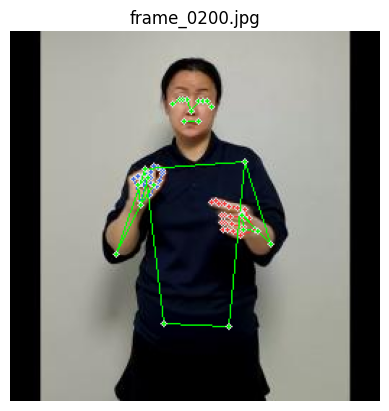

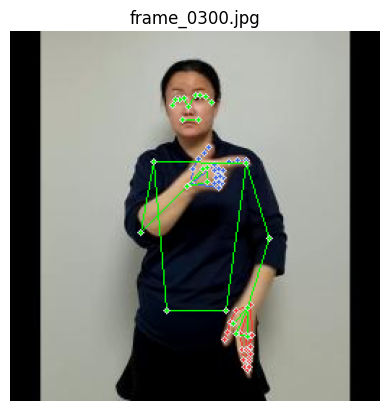

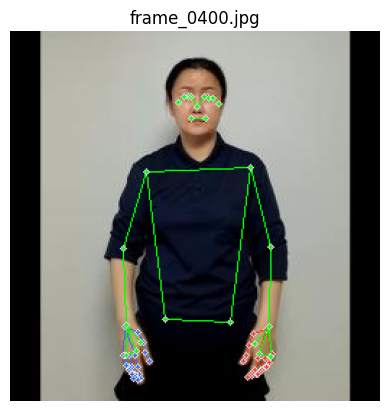

In [3]:
# Toy Code
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

def read_images_from_path(path):
    images = {}
    for filename in sorted(os.listdir(path)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(path, filename)
            images[filename] = cv2.imread(image_path)
    return images

def get_keypoints(image, holistic, prev_results):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)

    # Use keypoint from neighboring frames if no keypoints are detected
    if not results.left_hand_landmarks and prev_results and prev_results.left_hand_landmarks:
        results.left_hand_landmarks = prev_results.left_hand_landmarks
    if not results.right_hand_landmarks and prev_results and prev_results.right_hand_landmarks:
        results.right_hand_landmarks = prev_results.right_hand_landmarks
    if not results.pose_landmarks and prev_results and prev_results.pose_landmarks:
        results.pose_landmarks = prev_results.pose_landmarks
    
    return results

def draw_skeleton(image, results):
    
    # Customizing color
    mp_drawing = mp.solutions.drawing_utils
    
    RED_COLOR = (57, 57, 243)
    GREEN_COLOR = (0, 255, 0)
    BLUE_COLOR = (225, 105, 65)

    # Customizing draw style
    left_hand_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=RED_COLOR)
    right_hand_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=BLUE_COLOR)
    pose_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=GREEN_COLOR)

    # Draw skeleton on image
    annotated_image = image.copy()
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image, results.left_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=left_hand_drawing_spec, connection_drawing_spec=left_hand_drawing_spec,
        )
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image, results.right_hand_landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=right_hand_drawing_spec, connection_drawing_spec=right_hand_drawing_spec,
        )
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=pose_drawing_spec, connection_drawing_spec=pose_drawing_spec,
        )

    return annotated_image

def process_images(path, frame_interval):
    images = read_images_from_path(path)
    keypoints = {}
    all_keypoints = []

    # MediaPipe Holistic processing
    mp_holistic = mp.solutions.holistic
    with mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.001, model_complexity=2) as holistic:
        prev_results = None
        for filename, image in images.items():
            results = get_keypoints(image, holistic, prev_results)
            prev_results = results
            keypoints[filename] = results
            
            if results.left_hand_landmarks:
                left_hand_keypoints = [keypoint for keypoint in results.left_hand_landmarks.landmark]
                all_keypoints.extend(left_hand_keypoints)
            if results.right_hand_landmarks:
                right_hand_keypoints = [keypoint for keypoint in results.right_hand_landmarks.landmark]
                all_keypoints.extend(right_hand_keypoints)
            if results.pose_landmarks:
                pose_keypoints = [keypoint for keypoint in results.pose_landmarks.landmark]
                all_keypoints.extend(pose_keypoints)
    
    for i, (filename, image) in enumerate(images.items()):
        if i % frame_interval == 0:
            annotated_image = draw_skeleton(image, keypoints[filename])
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(filename)
            plt.axis('off')
            plt.show()
            
    return all_keypoints

# Your video frame image path completed our sign processor
sample_path = ' '
frame_interval = 100 # Wanted frame interval

all_keypoints = process_images(sample_path, frame_interval)